In [25]:
# Import Libraries
import pandas as pd
import numpy as np 
import glob
import os
from os.path import isfile, join
import soundfile as sf 
import sys
import librosa 
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Audio
import scipy.io.wavfile
from scipy.fftpack import dct
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# PreProcessing

In [13]:
# Hamming Window
# Set paths
home = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Baseline_Shortened_Cropped/"
destination = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Hamming_Shortened_Cropped/"

# Get list of all files in home directory
homeList = os.listdir(home)

# Loop through all files in home directory
for dir in homeList:
    # Load audio file
    signal, sr = librosa.load(home + dir)
    
    # Calculate window length and hop length
    window_length = int(sr * 0.025) # 25ms window length
    hop_length = int(sr * 0.010) # 10ms hop length
    
    # Create Hamming window
    hamming_window = hamming(window_length)
    
    # Pad signal to ensure it can be split into frames without overlap
    n_frames = int(np.ceil(len(signal) / hop_length))
    signal_length = n_frames * hop_length
    padding = signal_length - len(signal)
    signal_padded = np.pad(signal, (0, padding), 'constant', constant_values=0)
    
    # Apply Hamming window to signal using overlapping frames
    frames = librosa.util.frame(signal_padded, frame_length=window_length, hop_length=hop_length)
    windowed_frames = frames * hamming_window[:, np.newaxis]
    signal_hamming = np.zeros(len(signal_padded))
    for i in range(frames.shape[1]):
        start = i * hop_length
        end = start + window_length
        signal_hamming[start:end] += windowed_frames[:, i]
    signal_hamming = signal_hamming[:len(signal)]
    
    # Save the modified audio file to destination directory
    savePath = destination + dir
    sf.write(savePath, signal_hamming, sr)


In [26]:
# Feature Extract MFCC
from os import listdir
from os.path import isfile, join
data = []
label = []
Path = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Hamming_Shortened_Cropped/"
files = [f for f in listdir(Path) if isfile(join(Path, f))]
for x in files:
    filePath = Path + x
    label.append(x[0])
    signal, sr = librosa.load(filePath, sr=None)
    #mfcc = librosa.feature.mfcc(signal, n_fft=2048, hop_length = 256, n_mfcc = 20) 
    mfcc = librosa.feature.mfcc(signal, n_fft=2048, hop_length = 256, n_mfcc = 18) 
    #mfcc_1d = np.ravel(mfcc)
    data.append(mfcc)

In [27]:
data = np.array(data)
data.shape

(992, 18, 259)

In [28]:
X = np.expand_dims(data, axis=3)
X.shape

(992, 18, 259, 1)

In [29]:
label_new = []
for i in range(len(label)):
    if label[i] == 'n': #Neutral
        x=3
    elif label[i] == 'h': #Happy
        x=0
    elif label[i] == 's': #S
        x=1
    elif label[i] == 'a': #Angry
        x = 2
    label_new.append(x)

#print(label_new)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, label_new, test_size = 0.2)

In [31]:
X_train = np.array(x_train)
X_test = np.array(x_test)
Y_train = np.array(y_train)
Y_test = np.array(y_test)
print(X_train.shape)

(793, 18, 259, 1)


In [32]:
# This model gives 62% with 30 mfccs, 75.6% for 18 mfccs
# change epochs from 20 - 24
model = Sequential()
from keras.layers import BatchNormalization
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(18, 259, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 18, 259, 64)       640       
                                                                 
 batch_normalization_5 (Batc  (None, 18, 259, 64)      256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 259, 64)       36928     
                                                                 
 batch_normalization_6 (Batc  (None, 18, 259, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 129, 64)       0         
 2D)                                                             
                                                      

In [33]:
# Train and Test Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=32 , epochs= 20 , verbose=1, validation_data=(X_test, Y_test))

Epoch 1/20
25/25 [==============================] - 113s 4s/step - loss: 1.5021 - accuracy: 0.4741 - val_loss: 26.8977 - val_accuracy: 0.2965
Epoch 2/20
25/25 [==============================] - 105s 4s/step - loss: 0.9346 - accuracy: 0.6381 - val_loss: 12.2759 - val_accuracy: 0.3719
Epoch 3/20
25/25 [==============================] - 91s 4s/step - loss: 0.7727 - accuracy: 0.6986 - val_loss: 8.2981 - val_accuracy: 0.2764
Epoch 4/20
25/25 [==============================] - 90s 4s/step - loss: 0.5888 - accuracy: 0.7806 - val_loss: 3.9626 - val_accuracy: 0.3518
Epoch 5/20
25/25 [==============================] - 86s 3s/step - loss: 0.4874 - accuracy: 0.8108 - val_loss: 4.2884 - val_accuracy: 0.3266
Epoch 6/20
25/25 [==============================] - 86s 3s/step - loss: 0.3481 - accuracy: 0.8752 - val_loss: 2.3770 - val_accuracy: 0.4372
Epoch 7/20
25/25 [==============================] - 93s 4s/step - loss: 0.2764 - accuracy: 0.9067 - val_loss: 1.5224 - val_accuracy: 0.5276
Epoch 8/20
25/25

In [34]:
# Calculate precision and recall
# Get the predicted probabilities for the validation set
y_pred_proba = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute precision and recall using scikit-learn metrics
from sklearn.metrics import precision_score, recall_score
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)

# Pre-Emphasis
# Pre-Emphasis + Windowing: Precision: 77.97% Recall: 75.37%

7/7 [==============================] - 6s 687ms/step
Precision: 0.7341773804085362
Recall: 0.7185929648241206


7/7 [==============================] - 5s 676ms/step - loss: 1.1539 - accuracy: 0.7186
Accuracy of our model on test data :  71.85929417610168 %


ValueError: x and y must have same first dimension, but have shapes (24,) and (20,)

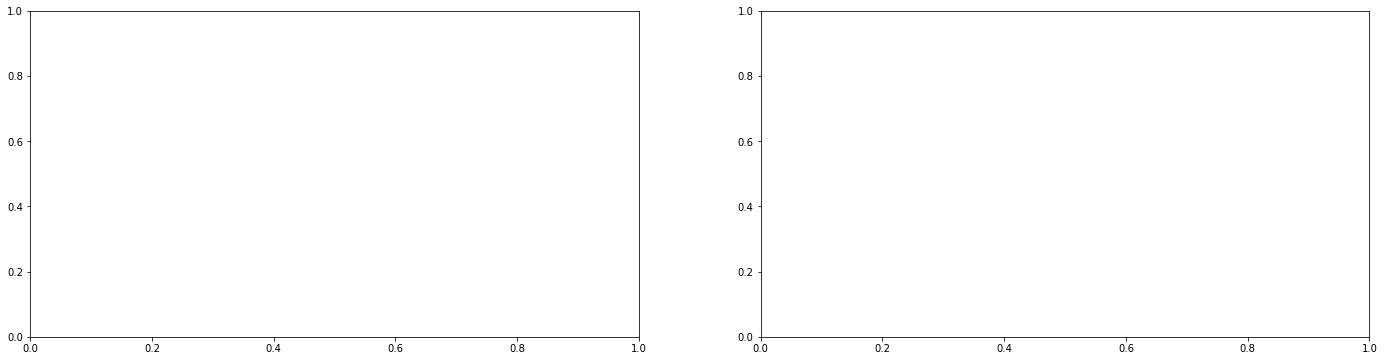

In [35]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

epochs = [i for i in range(24)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(24,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss: Hamming Window')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy: Hamming Window')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# make predictions on the test set
y_pred = model.predict(x_test)

# define y_true as the one-hot encoded version of the test labels
y_true = np.zeros((len(y_test), 4)) # 4 is the number of emotions being classified
y_true[np.arange(len(y_test)), y_test] = 1

# convert y_pred from probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1)

# define y_pred as the one-hot encoded version of the predicted labels
y_pred = np.zeros((len(predicted_labels), 4)) # 4 is the number of emotions being classified
y_pred[np.arange(len(predicted_labels)), predicted_labels] = 1

# compute confusion matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')
labels = ['Happy', 'Sad', 'Angry', 'Neutral'] # replace with your own emotion labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

# add axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Pre-Emphasis + Windowing')

# show the plot
plt.show()


In [23]:
best_val_acc = 0.0
best_epoch = None
num_epochs = 24
count = 0
Epoch_list = [1, 2 ,3,4,5,6, 8, 10, 14, 16, 18, 20, 24]
HistoryData = []
Val_loss_Data = []
Val_Acc_Data = []
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
for Loop_Var in Epoch_list:
    # Train the model for one epoch
    history = model.fit(X_train, Y_train, batch_size=32 , epochs=Loop_Var , verbose=1, validation_data=(X_test, Y_test))
    HistoryData.append(history)

    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)
    Val_loss_Data.append(val_loss)
    Val_Acc_Data.append(val_acc)

    # Check if this epoch had the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = Loop_Var
        # Save the model weights for the best epoch
        model.save_weights('best_model_weights.h5')
    count = count + 1
    print(count)
print('Loop Completed')
# Load the weights for the best epoch
model.load_weights('best_model_weights.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)

print("Best epoch: {} with validation accuracy: {}".format(best_epoch, best_val_acc))
print("Test loss: {} Test accuracy: {}".format(test_loss, test_acc))

7/7 [==============================] - 5s 693ms/step - loss: 44.7870 - accuracy: 0.2161
1
Epoch 1/2
25/25 [==============================] - 112s 4s/step - loss: 0.8988 - accuracy: 0.6520 - val_loss: 14.7401 - val_accuracy: 0.3518
Epoch 2/2
7/7 [==============================] - 6s 848ms/step - loss: 7.5212 - accuracy: 0.3568
2
Epoch 1/3
25/25 [==============================] - 92s 4s/step - loss: 0.5498 - accuracy: 0.8146 - val_loss: 5.5013 - val_accuracy: 0.3467
Epoch 2/3
25/25 [==============================] - 76s 3s/step - loss: 0.4984 - accuracy: 0.8108 - val_loss: 7.2135 - val_accuracy: 0.2211
Epoch 3/3
7/7 [==============================] - 4s 607ms/step - loss: 2.2239 - accuracy: 0.4724
3
Epoch 1/4
25/25 [==============================] - 75s 3s/step - loss: 0.2407 - accuracy: 0.9180 - val_loss: 1.0119 - val_accuracy: 0.7085
Epoch 2/4
25/25 [==============================] - 76s 3s/step - loss: 0.1674 - accuracy: 0.9369 - val_loss: 0.8703 - val_accuracy: 0.6683
Epoch 3/4
25/25

7/7 [==============================] - 8s 772ms/step - loss: 1.1788 - accuracy: 0.7588
9
Epoch 1/16
25/25 [==============================] - 135s 5s/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.2609 - val_accuracy: 0.7437
Epoch 2/16
25/25 [==============================] - 136s 6s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2628 - val_accuracy: 0.7789
Epoch 3/16
25/25 [==============================] - 141s 6s/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 1.4156 - val_accuracy: 0.7437
Epoch 4/16
25/25 [==============================] - 139s 6s/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 1.2737 - val_accuracy: 0.7588
Epoch 5/16
25/25 [==============================] - 40985s 1708s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.1824 - val_accuracy: 0.7286
Epoch 6/16
25/25 [==============================] - 106s 4s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3110 - val_accuracy: 0.7085
Epoch 7/16
25/25 [==============================] - 106s 4s/

25/25 [==============================] - 79s 3s/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 1.5744 - val_accuracy: 0.7136
Epoch 3/24
25/25 [==============================] - 87s 3s/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 1.5098 - val_accuracy: 0.7437
Epoch 4/24
25/25 [==============================] - 97s 4s/step - loss: 0.0047 - accuracy: 0.9975 - val_loss: 1.4734 - val_accuracy: 0.7136
Epoch 5/24
25/25 [==============================] - 101s 4s/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 1.3003 - val_accuracy: 0.7286
Epoch 6/24
25/25 [==============================] - 106s 4s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2830 - val_accuracy: 0.7387
Epoch 7/24
25/25 [==============================] - 109s 4s/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 1.2533 - val_accuracy: 0.7638
Epoch 8/24
25/25 [==============================] - 151s 6s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2210 - val_accuracy: 0.7588
Epoch 9/24
25/25 [=========

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Text(0.5, 1.0, 'Windowed: CASIA Anger')

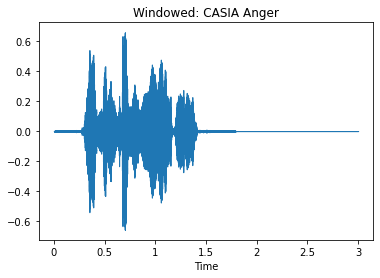

In [37]:
# Print wavefile 
Path = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Hamming_Shortened_Cropped/a_C_201-angry-liuchanhg.wav"
signal, sr = librosa.load(Path)
librosa.display.waveshow(signal, sr=sr)
plt.title("Windowed: CASIA Anger")

Text(0.5, 1.0, 'Baseline: CASIA Anger')

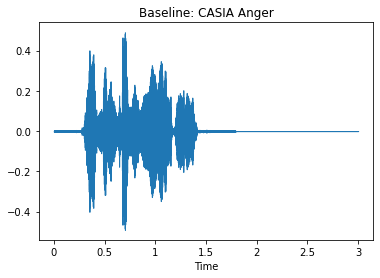

In [39]:
# Print wavefile 
Path = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Baseline_Shortened_Cropped/a_C_201-angry-liuchanhg.wav"
signal, sr = librosa.load(Path)
librosa.display.waveshow(signal, sr=sr)
plt.title("Baseline: CASIA Anger")